# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
# the below code is meant to display multiple outputs.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from collections import defaultdict
import random


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head(10)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
df_distribution = df.groupby('email').agg({'article_id': 'count'}).\
rename(columns = {'article_id' :'count_views'}).\
sort_values('count_views')

df_distribution.describe()

,count_views
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = df_distribution.describe().loc['50%','count_views'] # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = df_distribution.describe().loc['max','count_views']# The maximum number of user-article interactions by any 1 user is 364.


In [6]:
median_val
max_views_by_user

3.0

364.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c07d70438>]], dtype=object)

Text(0.5,1,'distribution of number of articles viewed by user')

Text(0,0.5,'frequency')

Text(0.5,0,'number of articles viewed')

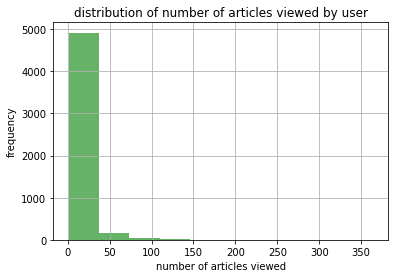

In [7]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
df_distribution.reset_index(drop = True).hist(color = 'g', alpha = .6)
plt.title('distribution of number of articles viewed by user')
plt.ylabel('frequency')
plt.xlabel('number of articles viewed')

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
#explore data
df_content_copy = df_content.copy()
df_content_copy.shape

#remove duplicates
duplicates = df_content_copy[df_content_copy.duplicated()].shape[0]
print('number of duplicates : {}'.format(duplicates))
df_content_copy.drop_duplicates(inplace = True)



(1056, 5)

number of duplicates : 0


In [9]:
# Remove any rows that have the same article_id - only keep the first
article_id_duplicated = df_content_copy[df_content_copy.article_id.duplicated()].article_id.tolist()
print("number of article_id duplicates : {}. Let's remove them!".format(len(article_id_duplicated)))
df_content_copy[df_content_copy.article_id.duplicated()]
df_content_copy = df_content_copy.drop_duplicates(subset=['article_id'], keep='first')
df_content_copy.shape

number of article_id duplicates : 5. Let's remove them!


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
#The number of unique articles that have an interaction with a user

df_copy = df.copy()
df_copy.article_id.nunique()

714

In [11]:
#The number of unique articles in the dataset (whether they have any interactions or not)
df_content_copy.article_id.nunique()

1051

In [12]:
#The number of unique users in the dataset. (excluding null values)
df_copy.email.isnull().sum()
df_copy.article_id.isnull().sum()
df_copy.email.nunique()

17

0

5148

In [13]:
#The number of user-article interactions in the dataset
df_copy.shape[0]

45993

In [14]:
unique_articles = df_copy.article_id.nunique() # The number of unique articles that have at least one interaction

total_articles = df_content_copy.article_id.nunique() # The number of unique articles on the IBM platform

unique_users = df_copy.email.nunique() # The number of unique users

user_article_interactions = df_copy.shape[0] # The number of user-article interactions


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
ranking = df_copy.groupby('article_id').agg({'email' : 'count'}).\
rename(columns = {'email' : 'views_count'}).\
sort_values('views_count',ascending = False).reset_index().iloc[:2]

most_viewed_article_id = ranking.article_id[0]
most_viewed_article_id

frequence_of_views = ranking.views_count[0]
frequence_of_views

1429.0

937

In [16]:
most_viewed_article_id = str(ranking.article_id[0])# The most viewed article in the dataset as a string with one value following the decimal 

max_views = ranking.views_count[0]# The most viewed article in the dataset was viewed how many times?


In [17]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [19]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    top_articles = df.groupby('title').agg({'user_id' : 'count'}).\
    rename(columns = {'user_id' : 'views_count'}).\
    sort_values('views_count',ascending = False).reset_index().title[:n]
    
    top_articles = [val for val in top_articles ]
    
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_article_ids = list(df.groupby('article_id').agg({'user_id' : 'count'}).\
    rename(columns = {'user_id' : 'views_count'}).\
    sort_values('views_count',ascending = False).reset_index().article_id[:n])
    
    top_article_ids = [val for val in top_article_ids ]
 
    return top_article_ids # Return the top article ids

In [20]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [21]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [22]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id','article_id']).min().reset_index()[['user_id','article_id']]
    user_item['value'] = 1
    user_item = user_item.groupby(['user_id','article_id']).min()['value'].unstack()
    user_item = user_item.fillna(0).astype('int32')
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [23]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to a given user
    most_similar_users = user_item.loc[user_id].dot(np.transpose(user_item))
    
    # sort by similarity
    most_similar_users = most_similar_users[most_similar_users!=0].\
        sort_values(ascending = False)

    # remove the own user's id
    most_similar_users = most_similar_users[most_similar_users.index !=user_id].index.values.tolist()

    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 4459, 203, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df[df.article_id.astype('str').isin(article_ids)].\
        groupby('article_id').title.max())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids_idx = list(np.where(user_item.loc[user_id]==np.max(user_item.loc[user_id]))[0])
    
    article_ids = user_item.loc[user_id].index[article_ids_idx].astype('float32').astype('str')
    
#     article_names = list(df_content[df_content.article_id.\
#                                     isin(article_ids.astype('str'))].doc_full_name)
    
    article_names = list(df[df.article_id.astype('str').\
                                        isin(article_ids)].groupby('article_id').max().title)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    most_familiar_users = find_similar_users(user_id)

    user_article_ids = get_user_articles(user_id)[0]

#     recs = defaultdict(set)
    recs = []
    
    for familiar_user in most_familiar_users:
        familiar_user_article = get_user_articles(familiar_user)[0]
        rec_temp = np.setdiff1d(familiar_user_article,user_article_ids)
        rec_temp = np.setdiff1d(rec_temp,recs)
        rec_temp = list(rec_temp)
        if len(rec_temp) == 0:
            continue
        start = len(recs)
        end = (len(rec_temp) + start)
        if end > m:
            k =(m-start)
            #items are chosen arbitrarily
            rec_temp = random.sample(rec_temp,k = k)
            recs.extend(rec_temp)
            break
        else:
            recs.extend(rec_temp)
 
       
    return recs # return your recommendations for this user_id    

In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['modeling energy usage in new york city',
 'using bigdl in dsx for deep learning on spark',
 'web picks (week of 4 september 2017)',
 'twelve\xa0ways to color a map of africa using brunel',
 'get social with your notebooks in dsx',
 'machine learning for the enterprise',
 'using rstudio in ibm data science experience',
 'ml algorithm != learning machine',
 'programmatic evaluation using watson conversation',
 'visualize data with the matplotlib library']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user 
                    to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of 
    interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to a given user
    most_similar_users = user_item.loc[user_id].dot(np.transpose(user_item))
    most_similar_users = most_similar_users[most_similar_users!=0]
    most_similar_users.name = 'similarity'
    

    # count of interactions per user
    user_interactions = df.user_id.value_counts()
    user_interactions.name = 'num_interactions'

    # create neighbors_df
    neighbors_df = pd.concat([most_similar_users,user_interactions], axis = 1).\
        reset_index().rename(columns = {'index':'neighbor_id'})
    
    #remove Nan values
    neighbors_df = neighbors_df.fillna(0)

    # remove the own user's id and sort
    neighbors_df = neighbors_df.query("neighbor_id != @user_id and similarity!=0.0").\
        sort_values(['similarity','num_interactions'], ascending = False)
        
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # similar users
    most_similar_users = list(get_top_sorted_users(user_id)['neighbor_id'])

    #list of articles of the provided user
    user_article_ids = get_user_articles(user_id)[0]

    # article_ids are ordered by number of interactions 
    ordered_article_ids = get_top_article_ids(-1)

    #for each familiar user, we get the articles not yet seen by the provided user
    recs = defaultdict(set)
    for similar_user in most_similar_users:
        similar_user_article = get_user_articles(similar_user)[0]
        rec_temp = np.setdiff1d(similar_user_article,user_article_ids)
        rec_temp = list(rec_temp)

        if len(rec_temp) == 0:
            continue
        
        start = len(recs)
        end = (len(rec_temp) + start)
    
    # we get the list of recs according to the top list of articles 
        new_rec_temp = []
        if end > m:
            k = m-start
            for i in list(map(str,ordered_article_ids)):
                if i in rec_temp:
                    new_rec_temp.append(i)
                else:
                    continue
            new_rec_temp =new_rec_temp[:k]
           
            recs[user_id].update(new_rec_temp)
            break
        else:
            for i in list(map(str,ordered_article_ids)):
                if i in rec_temp:
                    new_rec_temp.append(i)
                else:
                    continue
            recs[user_id].update(new_rec_temp)
    recs = recs[user_id]
    rec_names = list(get_article_names(recs))

    
    return recs, rec_names

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
{'1427.0', '1368.0', '1170.0', '1364.0', '1160.0', '1162.0', '1354.0', '1330.0', '1351.0', '1304.0'}

The top 10 recommendations for user 20 are the following article names:
['analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'movie recommender system with spark machine learning', 'predicting churn with the spss random tree algorithm', 'putting a human face on machine learning', 'use xgboost, scikit-learn & ibm watson machine learning apis']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
get_top_sorted_users(1).neighbor_id.iloc[0]
get_top_sorted_users(131).neighbor_id.iloc[9]


3933

242

In [32]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 

user131_10th_sim = 242 # Find the 10th most similar user to user 131




In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

In case we are given a new user, it is clear he has no interactions with any articles yet, hence we cannot relate him to any other users based on similarities of interactions. It would then make sense to use the rank based recommendations to present him with the top list of articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [34]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(map(str,get_top_article_ids(10)))# Your recommendations here


In [35]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [36]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [37]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [38]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [39]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [40]:
# Perform SVD on the User-Item Matrix Here
user_item_matrix.shape
u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices
u.shape, s.shape, vt.shape
u
s
vt

(5149, 714)

((5149, 5149), (714,), (714, 714))

array([[ -4.30899801e-02,   8.30671762e-03,   2.75704572e-02, ...,
         -1.77727253e-05,   4.70888947e-05,  -5.97808463e-03],
       [ -1.03765691e-02,   1.64771768e-02,   6.04781444e-03, ...,
          1.08681934e-03,   6.95169310e-04,  -9.60961798e-04],
       [ -4.98474594e-02,   1.44789670e-03,  -1.64960631e-02, ...,
          2.33057444e-03,   2.59445918e-04,   2.50334072e-03],
       ..., 
       [ -3.22580101e-05,  -7.76317124e-05,   5.55685276e-05, ...,
          9.30996264e-01,  -1.44195551e-04,  -6.26238570e-04],
       [ -2.46741942e-03,   3.80247363e-03,  -4.46702539e-03, ...,
         -1.16262150e-04,   9.93261270e-01,  -4.37194756e-04],
       [ -4.91946427e-04,  -1.00943223e-03,   4.99509739e-04, ...,
         -3.02094282e-04,  -9.19094490e-05,   9.68258051e-01]])

array([  5.53457037e+01,   2.32486418e+01,   2.17600228e+01,
         2.06583341e+01,   1.99708867e+01,   1.95569462e+01,
         1.91632342e+01,   1.87197508e+01,   1.83438615e+01,
         1.80639261e+01,   1.76377686e+01,   1.74335474e+01,
         1.74301733e+01,   1.70930876e+01,   1.67638529e+01,
         1.64669871e+01,   1.64559512e+01,   1.63068949e+01,
         1.61666030e+01,   1.57444047e+01,   1.57038805e+01,
         1.55878977e+01,   1.55013389e+01,   1.53746023e+01,
         1.52212789e+01,   1.50401111e+01,   1.49482365e+01,
         1.47737529e+01,   1.46704332e+01,   1.46097896e+01,
         1.45312074e+01,   1.44025711e+01,   1.43073643e+01,
         1.40654598e+01,   1.38995696e+01,   1.38576259e+01,
         1.37810084e+01,   1.36388289e+01,   1.36055830e+01,
         1.35749215e+01,   1.35196309e+01,   1.33503810e+01,
         1.33107854e+01,   1.31843779e+01,   1.30764996e+01,
         1.30470484e+01,   1.29137238e+01,   1.28999043e+01,
         1.27923679e+01,

array([[ -2.21822365e-03,  -1.13697491e-03,  -8.25820256e-03, ...,
         -7.89214713e-03,  -2.78398235e-02,  -3.49679488e-04],
       [  2.07736845e-03,   3.86642452e-04,   1.51981454e-03, ...,
         -1.56120895e-02,   9.70825293e-04,  -4.30034249e-04],
       [ -4.32111291e-04,   2.46676561e-03,   4.28288891e-03, ...,
          1.20613591e-02,   1.21832171e-02,   1.08416259e-03],
       ..., 
       [  0.00000000e+00,   3.15631941e-16,   1.84475856e-16, ...,
          5.48706963e-17,   9.44710455e-17,   1.23662293e-16],
       [  0.00000000e+00,  -2.38531913e-16,   2.65894675e-18, ...,
          1.71338757e-16,   7.09063975e-17,  -1.89755859e-16],
       [  0.00000000e+00,   2.26402240e-17,   3.39637767e-16, ...,
         -7.85447059e-17,  -6.56620070e-17,  -9.63564231e-17]])

In [41]:
#we check the number of missing values
arr = np.array(user_item_matrix)
num_missing_values = np.count_nonzero(~np.isnan(arr)) - len(arr)*len(arr[0])
num_missing_values

0

We can perform SVD because there is no nan value in the user_item_matrix matrix. In the course, we couldn't perform it on account of missing value

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

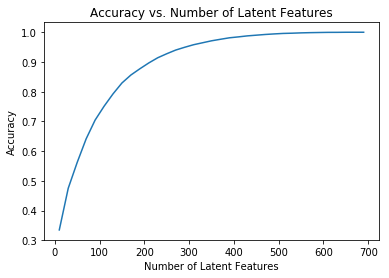

In [42]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [43]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    #user_item_train
    user_item_train = df_train.groupby(['user_id','article_id']).\
        min().reset_index()[['user_id','article_id']]
    user_item_train['value'] = 1
    user_item_train = user_item_train.\
        groupby(['user_id','article_id']).min()['value'].unstack()
    user_item_train = user_item_train.fillna(0).astype('int32')
    
    #user_item_test
    user_item_test = df_test.groupby(['user_id','article_id']).\
        min().reset_index()[['user_id','article_id']]
    user_item_test['value'] = 1
    user_item_test = user_item_test.\
        groupby(['user_id','article_id']).min()['value'].unstack()
    user_item_test = user_item_test.fillna(0).astype('int32')    
    
    #test_idx
    test_idx = user_item_test.index.values#.tolist() 
    
    #test_arts
    test_arts = user_item_test.columns#.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts



In [44]:
train_size = 40000
test_size = df.shape[0]-train_size
df_train = df.head(train_size)
df_test = df.tail(test_size)

user_item_train, user_item_test, test_idx, test_arts =\
    create_test_and_train_user_item(df_train, df_test)

In [45]:
#user_ids in the training set
train_idx = user_item_train.index.values

#common user ids between train and test sets
len(np.intersect1d(test_idx,train_idx))
est_test_idx = np.intersect1d(test_idx,train_idx)

#user ids we cannot predict
len(test_idx)-len(est_test_idx)

#article ids in the training set
train_arts = user_item_train.columns.values

#common article ids between train and test sets
len(np.intersect1d(test_arts,train_arts))
est_test_arts = np.intersect1d(test_arts,train_arts)

#article ids we cannot predict
user_item_test.shape[1]-len(est_test_arts)


20

662

574

0

In [46]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d 
}

t.sol_4_test(sol_4_dict)



Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [47]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

def predict(train_size,df):
    """
    INPUT :
        - train_size : the size of the training set
        - df : the dataframe df.
    OUTPUT :
        - call the function create_test_and_train_user_item to create 
        user_item_train, user_item_test, test_idx, test_arts
        - create the SVD components from user_item_train
        - By iterating over a list of number of features : calculate the 
        predictions and the associated errors for the test and train sets,
        based on common user ids and article ids.
        - produce a plot of accuracy vs number of features for both the test 
        and train sets.
    """

    test_size = df.shape[0]-train_size
    df_train = df.head(train_size)
    df_test = df.tail(test_size)
    
    user_item_train, user_item_test, test_idx, test_arts =\
        create_test_and_train_user_item(df_train, df_test)

    u_train, s_train, vt_train = np.linalg.svd(user_item_train)
        
    train_idx = user_item_train.index.values
    est_test_idx = np.intersect1d(test_idx,train_idx)

    train_arts = user_item_train.columns.values
    est_test_arts = np.intersect1d(test_arts,train_arts)

    num_latent_feats = np.arange(10,len(est_test_arts),20)

    training_sum_errs = []
    test_sum_errs = []
    diff_err_arr = []

    for k in num_latent_feats:

        # restructure with k latent features
        s_test_new, u_test_new, vt_test_new = np.diag(s_train[:k]),\
            u_train[user_item_train.index.isin(est_test_idx), :k],\
            vt_train[:k, user_item_train.columns.isin(est_test_arts)]

        # take dot product
        try :
            user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))

        except ValueError :
            break
            
        # compute error for each prediction to actual value
        test_diffs = np.subtract(np.array(user_item_test.loc[est_test_idx,est_test_arts]),\
                                     user_item_test_est)
        training_diffs = np.subtract(np.array(user_item_train.loc[est_test_idx,est_test_arts]),\
                                     user_item_test_est)

        # total errors and keep track of them
        test_err = np.sum(np.sum(np.abs(test_diffs)))
        test_sum_errs.append(test_err)

        training_err = np.sum(np.sum(np.abs(training_diffs)))
        training_sum_errs.append(training_err)    
        
    #plot both test and train scores:
    plt.figure(figsize=(15,10)) 
    plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/df.shape[0], label='test set', color = 'green')
    plt.plot(num_latent_feats, 1 - np.array(training_sum_errs)/df.shape[0], label='training set', color = 'purple')

    plt.legend()
    plt.xlabel('Number of Latent Features',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.title('Accuracy vs. Number of Latent Features',fontsize=20)
    plt.show()

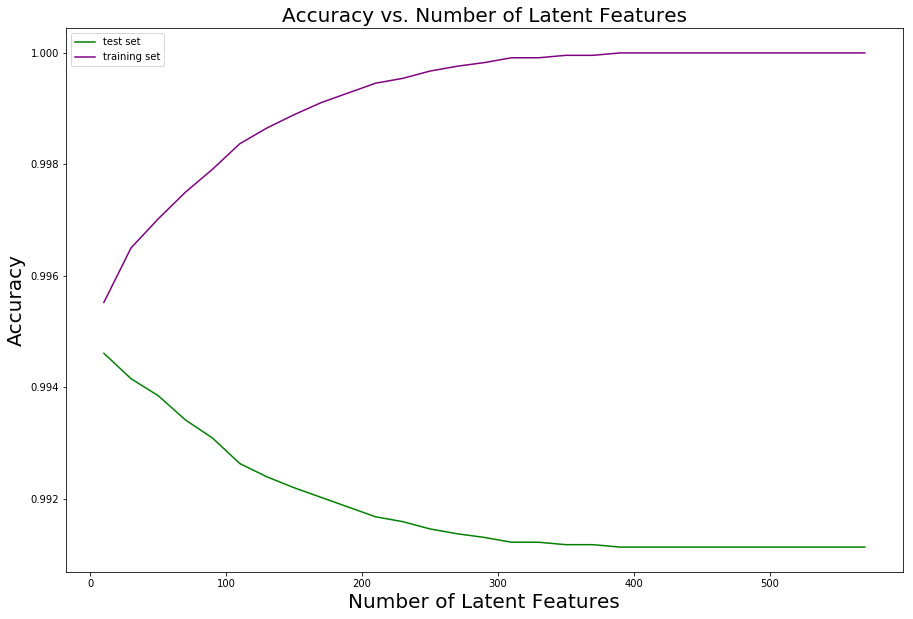

In [48]:
predict(40000,df)

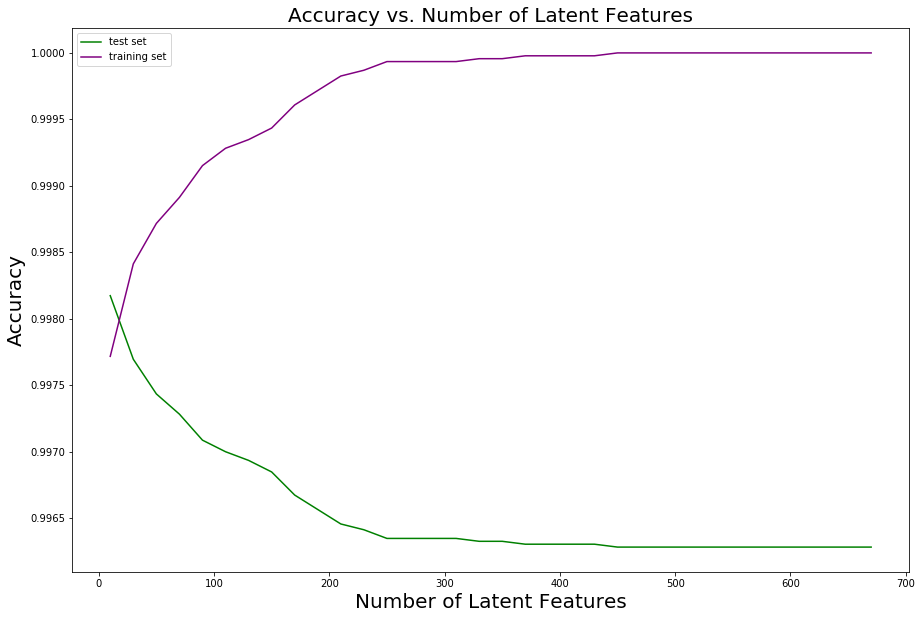

In [49]:
predict(28000,df)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**What can we conclude from the above results?**

We can observe that the accuracy is increasing along with the number of latent features for the training set, while it is the opposite for the test set.
This is an indication of overfitting and we should then opt for a low number of features.

Let's notice that if we decrease the size of the training set to between 13000 and 28000 rows, we can see the accuracy in the test set is faring better than in the training set, on condition that the number of features remains low. From the above graph, we can notice that the ideal number of features is set around 40. 

**Is accuracy a good metric to use here in this case? Does it provide us with a fair assessment of the model's performance?**

Basically, because we have only predicted 0s or 1s in our recommendations, the accuracy metric may not be a good indicator of whether the intended user would read or like them. Ideally, we would have been better off using user ratings instead of interactions. As a consequence, a good accuracy with the metric we used doesn't mean we made good recommendations.

**Is the current assessment framework robust enough to make conclusive results about the model?**

Using the SVD matrix factorization comes with a substantial drawback : we can only make predictions if the users and articles in the test set are existing on the training set.
We could complement SVD with other techniques like rank based recommendations to deal with new users or articles in the test set.

In our example of training set size of 40000, we could only predict for 20 users, which is not enough and there were 662 users we couldn't predict for...

**How could we validate the recommendations through A/B testing?**

As the recommendations are going online, we could use A/B testing to check if our new recommendations engine leads to more reads, clicks or ratings. 

In the online experiment, we would use a cookie-based diversion, wherein the user will be proposed randomly the new recommendations based on our model (experiment group) or the latest articles (control group), and we would record whether or not they click on the links to the recommended articles. 

The number of clicks would be the evaluation metric. If we observe an increase of this metric for the experiment group using our recommendations, this would validate the new recommendation model. 
The length of the experiment would depend on the statistical power required to validate the change in the recommendation model. Ex : if we observe that 10% of the control group tends to click on the pages of the most recent articles proposed, we could require a 12% for the experimental group.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0